# Problem Statment
Forcasting whether tempreture, max tempreture to be exact, from kaggle data set, UK weather data from 2015 to 2019.

In [1]:
# import libraries
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import time
from datetime import datetime

# Lines below are just to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read data set
df = pd.read_csv('clean_weather_data.csv')

In [3]:
# show head of data
df.head()

,day,tempMin,tempMax,summary,desc,cloudCover,humidity,windSpeed,visibility
0,2015-01-01,7.53,12.23,Possible light rain until evening.,rain,0.80,0.89,14.69,4.43
1,2015-01-02,3.58,7.15,Possible light rain throughout the day.,rain,0.62,0.79,15.04,5.64
2,2015-01-03,-0.61,6.54,Clear throughout the day.,rain,0.31,0.84,4.48,6.20
3,2015-01-04,-0.63,7.59,Mostly cloudy throughout the day.,partly-cloudy-day,0.78,0.85,4.35,6.22
4,2015-01-05,6.51,10.43,Overcast throughout the day.,partly-cloudy-day,0.85,0.91,6.20,5.91


In [4]:
# set the column day as index
df = df.set_index('day')

In [5]:
# change index to datetime object
df.index = pd.to_datetime(df.index)

In [6]:
# change frequncy to daily
df.index.freq = "D"

In [7]:
# show head 
df.head()

,tempMin,tempMax,summary,desc,cloudCover,humidity,windSpeed,visibility
day,,,,,,,,
2015-01-01,7.53,12.23,Possible light rain until evening.,rain,0.80,0.89,14.69,4.43
2015-01-02,3.58,7.15,Possible light rain throughout the day.,rain,0.62,0.79,15.04,5.64
2015-01-03,-0.61,6.54,Clear throughout the day.,rain,0.31,0.84,4.48,6.20
2015-01-04,-0.63,7.59,Mostly cloudy throughout the day.,partly-cloudy-day,0.78,0.85,4.35,6.22
2015-01-05,6.51,10.43,Overcast throughout the day.,partly-cloudy-day,0.85,0.91,6.20,5.91


In [8]:
# show tail
df.tail()

,tempMin,tempMax,summary,desc,cloudCover,humidity,windSpeed,visibility
day,,,,,,,,
2019-11-26,8.55,10.57,Mostly cloudy throughout the day.,rain,0.96,0.85,6.80,10.00
2019-11-27,5.79,9.40,Mostly cloudy throughout the day.,rain,0.87,0.85,6.82,9.03
2019-11-28,2.30,6.67,Mostly cloudy throughout the day.,partly-cloudy-day,0.40,0.79,5.15,10.00
2019-11-29,1.08,6.14,Mostly cloudy throughout the day.,clear-day,0.18,0.76,4.85,9.11
2019-11-30,0.42,5.69,Mostly cloudy throughout the day.,partly-cloudy-day,0.55,0.72,4.79,10.00


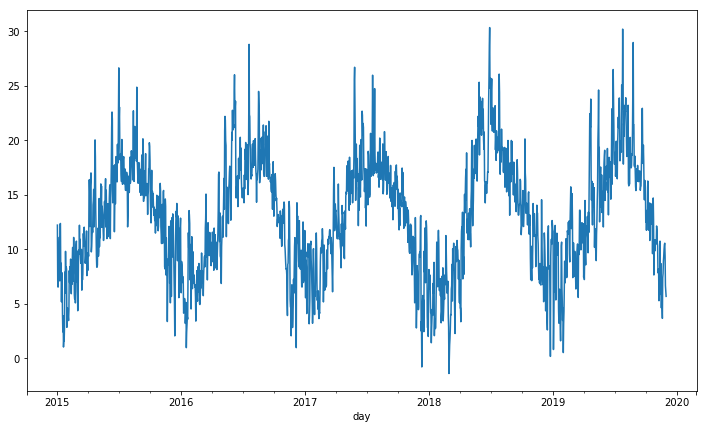

In [9]:
# plot temp to look for seasonality
df['tempMax'].plot(figsize=(12,7))

We can clearlly see that there is a seasonality for each 365 data point, yearly seasonality.

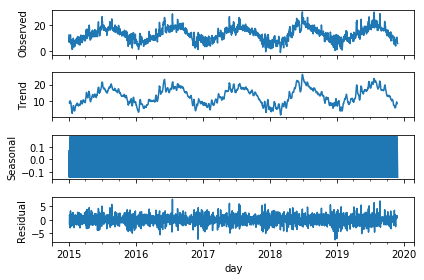

In [10]:
# seasonal_decompose 
seasonal_decompose(df['tempMax']).plot();

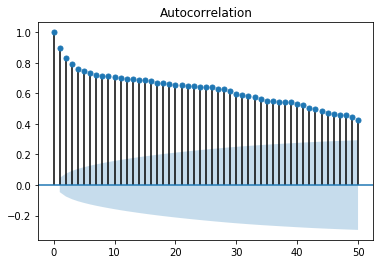

In [11]:
# acf plot
plot_acf(df['tempMax'] , lags=50);

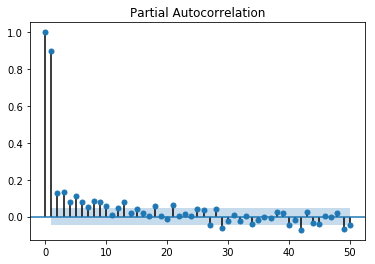

In [12]:
# pacf plot
plot_pacf(df['tempMax'] , lags=50);

In [13]:
# define Dickey-Fuller Test function
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [14]:
# Dickey-Fuller Test
adf_test(df.tempMax)

Augmented Dickey-Fuller Test: 
ADF test statistic        -2.774388
p-value                    0.062026
# lags used               20.000000
# observations          1774.000000
critical value (1%)       -3.434042
critical value (5%)       -2.863171
critical value (10%)      -2.567638
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


We can see the data is not stationary, so the 'd' parameter for sarimax have to be not equal to 0.

In [15]:
# do Dickey-Fuller Test, after 1 differencing
adf_test(df.tempMax-df.tempMax.shift(-1))

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.393752e+01
p-value                 4.959950e-26
# lags used             1.900000e+01
# observations          1.774000e+03
critical value (1%)    -3.434042e+00
critical value (5%)    -2.863171e+00
critical value (10%)   -2.567638e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


With differencing id 1, we changed the data to stationary.

In [16]:
# grid search to find arima parameters
# stepwise_model = auto_arima(df.tempMax, start_p=1, start_q=1,
#                           max_p=3, max_q=3,
#                             m=365,
#                            start_P=0, seasonal=True,
#                            d=1, D=1,
#                             trace=True,
#                            error_action='ignore',  
#                            suppress_warnings=True, 
#                            stepwise=True)
# print(stepwise_model.aic())

# SARIMAX order=(0, 1, 0), seasonal_order=(0, 1, 0, 365)

In [17]:
df = df['2017-01-01':]['tempMax']

In [18]:
# train test split so that the test set is for one year
train = df.iloc[:(len(df)-len(df['2018-11-30':'2019-11-30']))]
test = df.iloc[(len(df)-len(df['2018-11-30':'2019-11-30'])):]

In [19]:
# define the start and end of the prediction
start = len(train)
end = len(train) + len(test) - 1

In [21]:
# using sarimax model with the found parameters
model = SARIMAX(train,order=(0, 1, 0), seasonal_order=(0, 1, 0, 365),
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  Statespace Model Results                                 
===========================================================================================
Dep. Variable:                             tempMax   No. Observations:                  698
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 365)   Log Likelihood                -838.556
Date:                             Wed, 04 Dec 2019   AIC                           1679.113
Time:                                     10:56:15   BIC                           1682.915
Sample:                                 01-01-2017   HQIC                          1680.629
                                      - 11-29-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         9.2901      0.680     13.654      0.000       7.957      10.624
===================================================================================
Ljung-Box (Q):                       54.83   Jarque-Bera (JB):                 2.35
Prob(Q):                              0.06   Prob(JB):                         0.31
Heteroskedasticity (H):               0.77   Skew:                             0.16
Prob(H) (two-sided):                  0.17   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
# predict for one year
predictions = model.predict(start=start , end=end ,dynamic=False , typ = 'levels' ).rename('SARIMA(0,1,0)(0,1,0,365) Predictions')

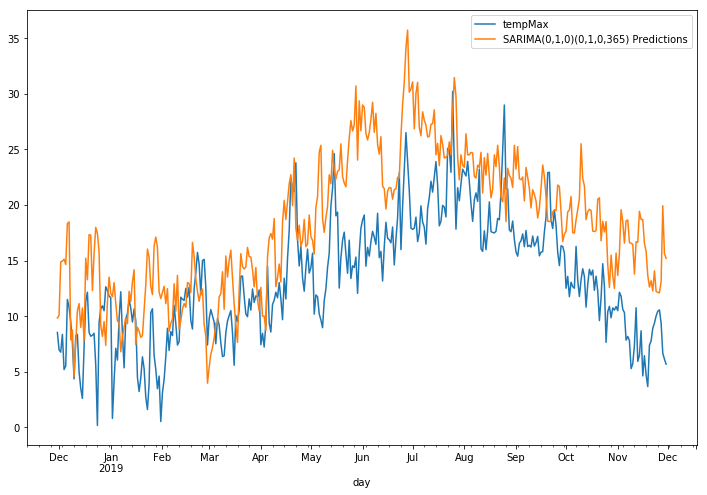

In [23]:
# compare predicted and actual
test.plot(legend=True, figsize=(12,8))
predictions.plot(legend=True)

We can see the the prediction is a little bit off, but this is prediction for each day for the next unkown year.

In [25]:
# rmse
rmse(test,predictions)

6.525122237826603

In [26]:
# compare the mean of both predictions and test
predictions.mean()

18.14579234972678

In [28]:
test.mean()

13.335136612021858

# Conclosuion
Using sarimax model we could forcast the teampreture a year ahead into the future, it could be improved by trying other models or add exanous variables to the sarimax model.